In [ ]:
'''
@Author: Rashmi
@Date: 2021-11-20 16:10
@Last Modified by: Rashmi
@Last Modified time: 2021-11-21  02:11
@Title : Perform SQL queries on csv files by accessing them from HDFS
Columns to consider user_name,boot_time,keyboard,mouse
1) Display users and their record counts
2) Finding users with highest number of average hours
3) Finding users with lowest number of average hours
4) Finding users with highest numbers of idle hours

'''

In [1]:
from pyspark.sql import *
from pyspark.sql import functions as func
spark = SparkSession.builder.getOrCreate()

2021-11-20 23:18:23,141 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


SELECTING DATATIME,BOOT TIME,KEYBOARD,MOUSE,USER NAME

In [2]:
df = spark.read.csv("hdfs://localhost:9000/sparkallcsv/*.csv",header=True)
df1 = df.select('DateTime','boot_time','keyboard','mouse','user_name')
df1.show()

+-------------------+--------------+--------+------+--------------------+
|           DateTime|     boot_time|keyboard| mouse|           user_name|
+-------------------+--------------+--------+------+--------------------+
|2019-09-19 08:40:02|0:09:59.262105|     1.0|  32.0|  iamnzm@outlook.com|
|2019-09-19 08:45:02|0:14:59.259253|     0.0|   0.0|  iamnzm@outlook.com|
|2019-09-19 08:50:01|0:19:58.817858|     0.0|   0.0|  iamnzm@outlook.com|
|2019-09-19 08:55:01|0:24:58.366251|    11.0| 900.0|  iamnzm@outlook.com|
|2019-09-19 09:00:01|0:29:59.008276|     2.0|  25.0|  iamnzm@outlook.com|
|2019-09-19 09:05:01|0:34:58.858791|    37.0| 336.0|  iamnzm@outlook.com|
|2019-09-19 09:05:01|0:05:19.424878|     0.0|  55.0|deepshukla292@gma...|
|2019-09-19 09:10:01|0:39:58.482956|     0.0| 136.0|  iamnzm@outlook.com|
|2019-09-19 09:10:01|0:10:19.516467|     6.0|1112.0|deepshukla292@gma...|
|2019-09-19 09:15:02|0:44:59.088574|     0.0|  84.0|  iamnzm@outlook.com|
|2019-09-19 09:15:02|0:15:20.211072|  

DISPLAY USERS AND RECORD COUNTS

In [6]:
'''1) Display users and their record counts'''
#create view table named as Data_Table
df1.createOrReplaceTempView("Data_Table")
users_count = spark.sql("SELECT user_name FROM Data_Table").groupby("user_name").count()
users_count.show()


2021-11-20 23:20:55,076 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|salinabodale73@gm...|  569|
|sharlawar77@gmail...|  580|
|rahilstar11@gmail...|  551|
|deepshukla292@gma...|  565|
|  iamnzm@outlook.com|  614|
|markfernandes66@g...|  508|
|damodharn21@gmail...|  253|
|bhagyashrichalke2...|  482|
+--------------------+-----+



FINDING USERS WITH HIGHEST NUMBER OF AVERAGE HOURS

In [13]:
'''Finding users with highest number of average hours 
i) finding active users from the view table Data_Table '''

avg_hr_df = spark.sql("SELECT user_name FROM Data_Table WHERE keyboard != 0 or mouse !=0")\
            .groupby("user_name").count()

avg_hr_df.show()

+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|salinabodale73@gm...|  436|
|sharlawar77@gmail...|  457|
|rahilstar11@gmail...|  399|
|deepshukla292@gma...|  475|
|  iamnzm@outlook.com|  459|
|markfernandes66@g...|  389|
|damodharn21@gmail...|  191|
|bhagyashrichalke2...|  361|
+--------------------+-----+



In [8]:
'''ii)creating table  and performing on count to convert the minutes
 into secs for each 5 minutes time interval as mentioned '''

df3 = avg_hr_df.createOrReplaceTempView("hour_view")
df4 = spark.sql("SELECT user_name,count,((((count-1) *5)*60)/6) as avg_secs from hour_view")
df4.show()

+--------------------+-----+--------+
|           user_name|count|avg_secs|
+--------------------+-----+--------+
|salinabodale73@gm...|  436| 21750.0|
|sharlawar77@gmail...|  457| 22800.0|
|rahilstar11@gmail...|  399| 19900.0|
|deepshukla292@gma...|  475| 23700.0|
|  iamnzm@outlook.com|  459| 22900.0|
|markfernandes66@g...|  389| 19400.0|
|damodharn21@gmail...|  191|  9500.0|
|bhagyashrichalke2...|  361| 18000.0|
+--------------------+-----+--------+



In [12]:
'''iii) coverting secs into hours
86400--total no of secs per day'''
from pyspark.sql.functions import *
highest_avg_hour = df4.withColumn("average hours",concat(floor(col("avg_secs") % 86400/3600), lit(":"),
            floor((col("avg_secs") % 86400) % 3600 / 60), lit (""),
            ))\
        .drop("avg_secs")\
        .sort(desc("average hours"))


highest_avg_hour.show()

+--------------------+-----+-------------+
|           user_name|count|average hours|
+--------------------+-----+-------------+
|deepshukla292@gma...|  475|         6:35|
|  iamnzm@outlook.com|  459|         6:21|
|sharlawar77@gmail...|  457|         6:20|
|salinabodale73@gm...|  436|          6:2|
|rahilstar11@gmail...|  399|         5:31|
|markfernandes66@g...|  389|         5:23|
|bhagyashrichalke2...|  361|          5:0|
|damodharn21@gmail...|  191|         2:38|
+--------------------+-----+-------------+



FINDING LOWEST NO. OF AVG HOURS

In [10]:
'''finding lowest no of avg hours'''
from pyspark.sql.functions import *
lowest_avg_hour = df4.withColumn("average hours",concat(floor(col("avg_secs") % 86400/3600), lit(":"),
            floor((col("avg_secs") % 86400) % 3600 / 60), lit (""),
            ))\
        .drop("avg_secs")\
        .sort(asc("average hours"))

lowest_avg_hour.show()

+--------------------+-----+-------------+
|           user_name|count|average hours|
+--------------------+-----+-------------+
|damodharn21@gmail...|  191|         2:38|
|bhagyashrichalke2...|  361|          5:0|
|markfernandes66@g...|  389|         5:23|
|rahilstar11@gmail...|  399|         5:31|
|salinabodale73@gm...|  436|          6:2|
|sharlawar77@gmail...|  457|         6:20|
|  iamnzm@outlook.com|  459|         6:21|
|deepshukla292@gma...|  475|         6:35|
+--------------------+-----+-------------+



FINDING USERS WITH HIGHEST NUMBERS OF IDLE HOURS

In [14]:
'''Finding users with highest numbers of idle hours'''
df5 = spark.sql("SELECT user_name FROM Data_Table WHERE keyboard == 0 and mouse == 0")\
            .groupby("user_name").count()

df5.show()

+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|salinabodale73@gm...|  133|
|sharlawar77@gmail...|  123|
|rahilstar11@gmail...|  152|
|deepshukla292@gma...|   90|
|  iamnzm@outlook.com|  155|
|markfernandes66@g...|  119|
|damodharn21@gmail...|   62|
|bhagyashrichalke2...|  121|
+--------------------+-----+



In [16]:
df5.createOrReplaceTempView("idle_hr_view")
df6 = spark.sql("SELECT user_name,count,((((count-1) *5)*60)/6) as avg_secs from idle_hr_view")
df6.show()

+--------------------+-----+--------+
|           user_name|count|avg_secs|
+--------------------+-----+--------+
|salinabodale73@gm...|  133|  6600.0|
|sharlawar77@gmail...|  123|  6100.0|
|rahilstar11@gmail...|  152|  7550.0|
|deepshukla292@gma...|   90|  4450.0|
|  iamnzm@outlook.com|  155|  7700.0|
|markfernandes66@g...|  119|  5900.0|
|damodharn21@gmail...|   62|  3050.0|
|bhagyashrichalke2...|  121|  6000.0|
+--------------------+-----+--------+



In [17]:
''' highest idle hours
coverting secs into hours
86400--total no of secs per day'''
from pyspark.sql.functions import *
highest_idle_hour = df6.withColumn("idle_hours",concat(floor(col("avg_secs") % 86400/3600), lit(":"),
            floor((col("avg_secs") % 86400) % 3600 / 60), lit (""),
            ))\
        .drop("avg_secs")\
        .sort(desc("idle_hours"))


highest_idle_hour.show()

+--------------------+-----+----------+
|           user_name|count|idle_hours|
+--------------------+-----+----------+
|  iamnzm@outlook.com|  155|       2:8|
|rahilstar11@gmail...|  152|       2:5|
|salinabodale73@gm...|  133|      1:50|
|sharlawar77@gmail...|  123|      1:41|
|bhagyashrichalke2...|  121|      1:40|
|markfernandes66@g...|  119|      1:38|
|deepshukla292@gma...|   90|      1:14|
|damodharn21@gmail...|   62|      0:50|
+--------------------+-----+----------+



VISUALIZATION THROUGH MATPLOTLIB

BAR GRAPH FOR USER_NAME AND THEIR COUNT

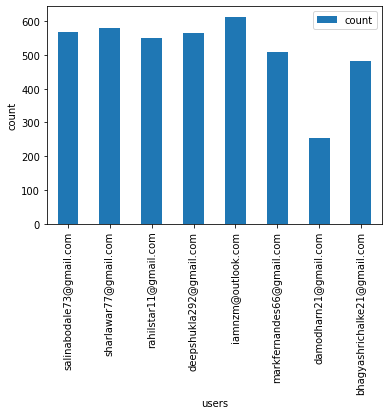

In [28]:
import matplotlib.pyplot as plt
# converting pyspark dataframe to pandas dataframe
data_frame = users_count.toPandas()
data_frame.plot(kind = 'bar',x='user_name',y='count')
plt.xlabel('users')
plt.ylabel('count')
plt.show()


BAR GRAPH FOR USER'S WITH HIGHEST AVERAGE HOURS

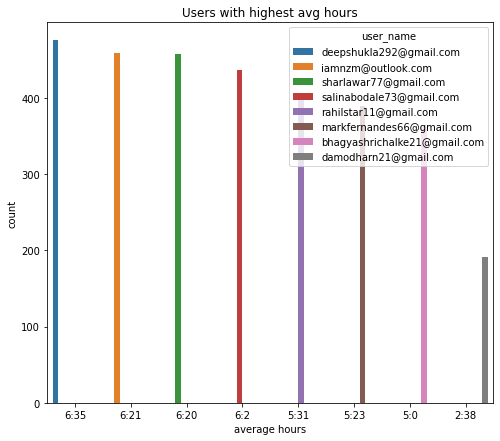

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
high_avg_df = highest_avg_hour.toPandas()
plt.figure(figsize = (8,7))
sns.barplot(x = 'average hours',y='count',data = high_avg_df,hue='user_name')
plt.title("Users with highest avg hours")
plt.show()


BAR GRAPH FOR USER'S WITH LOWEST AVERAGE HOURS

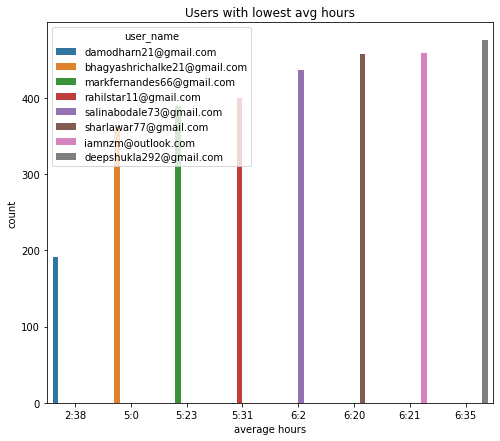

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
low_avg_df = lowest_avg_hour.toPandas()
plt.figure(figsize = (8,7))
sns.barplot(x = 'average hours',y='count',data = low_avg_df,hue='user_name')
plt.title("Users with lowest avg hours")
plt.show()

BAR GRAPH FOR USERS WITH HIGHEST NUMBERS OF IDLE HOURS 


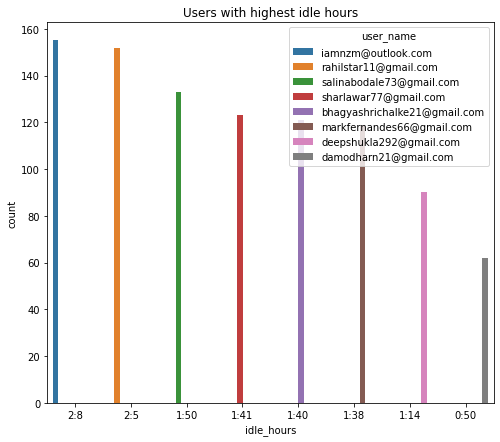

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
idle_df = highest_idle_hour.toPandas()
plt.figure(figsize = (8,7))
sns.barplot(x = 'idle_hours',y='count',data = idle_df,hue='user_name')
plt.title("Users with highest idle hours")
plt.show()